# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — её уже сделали ранее в прошлом проекте.

Нужно:
- разбить данные на 3 выборки: обучающую, валидационную и тестовую
- исследовать качество разных моделей машинного обучения для задачи классификации и сравнить результаты
- построить модель с максимально большим значением "accuracy" и довести долю правильных ответов модели до 0.75
- проверить модель на тестовой выборке
- проверить модель на адекватность

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Изучение файла
Начнем с загрузки и изучения файла. В задании указано, что предобработка данных была сделана ранее, проверим, все ли хорошо с данными :)

In [1]:
import pandas as pd
# для разделения выборки на обучающую и тестовую
from sklearn.model_selection import train_test_split
# для построения модели Дерево решений
from sklearn.tree import DecisionTreeClassifier
# для расчета метрики accuracy
from sklearn.metrics import accuracy_score
# для построения модели Случайный лес
from sklearn.ensemble import RandomForestClassifier
# для построения модели Логистическая регрессия
from sklearn.linear_model import LogisticRegression
# для проверки модели на адекватность методом classification_report
from sklearn.metrics import classification_report
# для создания baseline модели
from sklearn.dummy import DummyClassifier 

In [2]:
data = pd.read_csv('users_behavior.csv')
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В датасете 3214 объектов, 5 столбцов. Все столбцы названы корректно, пропусков нет, типы данных - с плавающей точкой и целые. Можно приступать к разбивке данных на выборки.

## Разбитие данных на выборки

У нас имеется один датасет с данными. Нам нужны три выборки: обучающая (для обучения модели), валидационная (для применения гиперпараметров) и тестовая (для итоговой проверки). Так как "спрятанной" тестовой выборки у нас нет, будем делить данные на три части в соотношении 3:1:1 (60%:20%:20%).

Для начала нужно создать переменные для признаков и целевого признака из нашего датасета. 
Целевой признак в данном проекте - название тарифа - столбец "is_ultra". Значение 1 - тариф "Ультра", значение 0 - тариф "Смарт". Создадим нужные нам переменные.

In [4]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

Теперь посмотрим, как распределены значения в целевом признаке.

In [5]:
target.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [6]:
# доля тарифа Смарт
sm = 2229 / target.shape[0]
sm

0.693528313627878

Тарифа Смарт намного больше (69%), чем тарифа Ультра. Чтобы обеспечить одинаковую репрезентативность объектов в обучающей, валидационной и тестовой выборках, разобьем данные на выборки так, чтобы в каждой были одинаковые пропорции тарифов. Используем для этого агрумент stratify.

Сперва разобьем наши данные на 2 выборки (обучающую и дополнительную) в пропорции 60% и 40%.

In [7]:
features_train, features_valid_test, target_train, target_valid_test = \
train_test_split(features, target, train_size=0.6, random_state=12345, stratify=target)

In [8]:
# проверим размеры
print(features_train.shape)
features_valid_test.shape

(1928, 4)


(1286, 4)

In [9]:
# проверим соотношение классов в обучающей выборке
target_train.value_counts()

0    1337
1     591
Name: is_ultra, dtype: int64

Теперь разделим меньшую (дополнительную) выборку еще на 2 части пополам, так мы получим валидационную и тестовую выборки.

In [10]:
features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345, \
                 stratify=target_valid_test)

In [11]:
# проверим размеры
print(features_valid.shape)
features_test.shape

(643, 4)


(643, 4)

In [12]:
# проверим соотношение классов в валидационной и тестовой выборках
print(target_valid.value_counts())
target_test.value_counts()

0    446
1    197
Name: is_ultra, dtype: int64


0    446
1    197
Name: is_ultra, dtype: int64

Итог: имеем 3 разные выборки с пропорциональным разбиением классов в целевом признаке, для каждой выборки создали переменные с признаками и целевым признаком. Можно приступать к построению и исследованию моделей.

## Модели для исследования

### Дерево решений
Начнем с самой популярной модели - дерево решений. Модель обучим на обучающей выборке.

In [13]:
# объявили модель Дерево решений
tree_model = DecisionTreeClassifier(random_state=12345)
# обучили на обучающей выборке
tree_model.fit(features_train, target_train)
# предсказали ответы на валидационной выборке
valid_predictions = tree_model.predict(features_valid)

Рассчитаем метрику accuracy - отношение числа правильных ответов к размеру выборки. Каждое наше неправильное предсказание — это неверная подсказка и потенциальная упущенная выгода для компании. Если клиент останется недоволен предложенным тарифом, он сменит оператора мобильной связи. И наоборот: чем выше точность классификации, тем больше прибыли принесёт продукт. Довольный клиент будет долгое время пользоваться новым тарифом + может порекомендовать тариф своим знакомым.

In [14]:
# на обучающей выборке
train_predictions = tree_model.predict(features_train)
train_accuracy = accuracy_score(target_train, train_predictions)
# на валидационной выборке
valid_predictions = tree_model.predict(features_valid)
valid_accuracy = accuracy_score(target_valid, valid_predictions)

print("Обучающая выборка:", train_accuracy)
print("Валидационная выборка:", valid_accuracy)

Обучающая выборка: 1.0
Валидационная выборка: 0.7013996889580093


Accuracy валидационной выборки достаточно низкий - 0.7. Модель отлично обучилась на тренировочной выборке, но запуталась в валидационной выборке - модель переобучилась.
Добавим гиперпараметр максимальную глубину дерева (от 1 до 5) для валидационной выборки и выберем лучшую модель.

In [15]:
best_model = None
tree_best_result = 0
for depth in range(1, 6):
    tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    tree_model.fit(features_train, target_train)
    valid_predictions = tree_model.predict(features_valid)
    result = accuracy_score(target_valid, valid_predictions)
    if result > tree_best_result:
        best_model = tree_model
        tree_best_result = result
    print("Макс. глубина дерева =", depth, "Accuracy: ", \
          accuracy_score(target_valid, valid_predictions))
        
print()
print("Accuracy лучшей модели:", tree_best_result)
print("Лучшая модель:", best_model)

Макс. глубина дерева = 1 Accuracy:  0.7402799377916018
Макс. глубина дерева = 2 Accuracy:  0.7729393468118196
Макс. глубина дерева = 3 Accuracy:  0.7776049766718507
Макс. глубина дерева = 4 Accuracy:  0.7542768273716952
Макс. глубина дерева = 5 Accuracy:  0.7853810264385692

Accuracy лучшей модели: 0.7853810264385692
Лучшая модель: DecisionTreeClassifier(max_depth=5, random_state=12345)


Accuracy увеличилась до 0.785. Лучшая модель Дерева решений имеет глубину дерева 5.

### Случайный лес

Попробуем новый алгоритм классификации — случайный лес. Случайный лес помогает улучшить результат предсказания и избежать переобучения.

Рассмотрим модель случайного леса с количеством деревьев от 1 до 100.

In [16]:
best_model = None
forest_best_result = 0
for est in range(1, 101):
    forest_model = RandomForestClassifier(random_state=12345, n_estimators=est)
    forest_model.fit(features_train, target_train)
    valid_predictions = forest_model.predict(features_valid)
    result = forest_model.score(features_valid, target_valid)
    if result > forest_best_result:
        best_model = forest_model
        forest_best_result = result

print("Accuracy наилучшей модели на валидационной выборке:", forest_best_result)
print("Лучшая модель:", best_model)

Accuracy наилучшей модели на валидационной выборке: 0.8118195956454122
Лучшая модель: RandomForestClassifier(n_estimators=58, random_state=12345)


Метрика accuracy увеличилась до 0.812 при количестве деревьев 58.
Если сделать гиперпараметр n_estimators больше, модель начнёт разрастаться и медленнее обучаться.

### Логистическая регрессия

Попробуем новый алгоритм — логистическую регрессию. В логистической регрессии параметров мало, поэтому и вероятность переобучения невелика.

Добавим дополнительные гиперпараметры: solver='lbfgs' и max_iter=1000. Первый гиперпараметр позволяет выбрать алгоритм, который будет строить модель. Алгоритм 'lbfgs' — один из самых распространённых. Гиперпараметром max_iter задаётся максимальное количество итераций обучения (по умолчанию 100 итераций). 

In [17]:
log_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
log_model.fit(features_train, target_train)
log_model.predict(features_valid) 
log_result = log_model.score(features_valid, target_valid) 

print("Accuracy модели на валидационной выборке:", log_result)

Accuracy модели на валидационной выборке: 0.7387247278382582


Accuracy данной модели ниже даже обычного Дерева решения: 0.739. Если увеличить количество итераций до 10_000 или до 100_000 - значение не меняется.
При использовании алгоритма "liblinear", значение Accuracy еще меньше: 0.718.

In [18]:
print("Accuracy модели Дерево решений:", tree_best_result)
print("Accuracy модели Случайный лес:", forest_best_result)
print("Accuracy модели Логистической регрессии:", log_result)

Accuracy модели Дерево решений: 0.7853810264385692
Accuracy модели Случайный лес: 0.8118195956454122
Accuracy модели Логистической регрессии: 0.7387247278382582


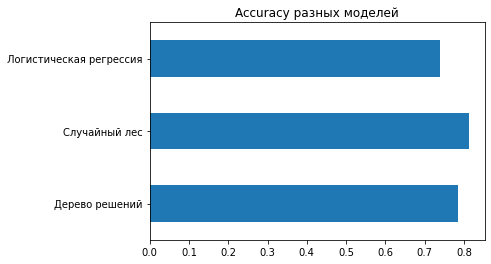

In [19]:
total = pd.Series({'Дерево решений': tree_best_result, 'Случайный лес': forest_best_result, \
                   'Логистическая регрессия': log_result})
total.plot(kind='barh', title='Accuracy разных моделей');

### Выводы
1. Самой обученной моделью оказалась Случайный лес при количестве 58 деревьев. Ее доля правильных решений: 0.812. Эту модель и будем проверять на тестовой выборке.
2. Модель Дерево решений при максимальной глубине дерева 5 ошибается чуть меньше, чем Случайный лес.
3. Модель Логистическая регрессия показала самый худший результат, так как связи между признаками и целевой переменной несут выраженный нелинейный характер.

## Проверка модели на тестовой выборке

Возьмем модель Случайный лес с 58-ю деревьями. Проверим ее на тестовой выборке.

In [20]:
best_model = RandomForestClassifier(random_state=12345, n_estimators=58)
best_model.fit(features_train, target_train)
test_predictions = best_model.predict(features_test)
result = best_model.score(features_test, target_test)

print("Accuracy модели на тестовой выборке:", result)

Accuracy модели на тестовой выборке: 0.8055987558320373


Получили accuracy чуть ниже, чем на валидационной выборке, но больше, чем 0.75. Модель проверку прошла.

Сейчас, когда гиперпараметры подобраны и валидационная выборка нам не нужна, мы можем обучить модель на большой выборке (обучающая + валидационная), а тестирование новой модели произвести уже на тестовой выборке.

Объединим обучающую и валидационные выборки.

In [21]:
features_train_valid = pd.concat([features_train, features_valid], axis=0)

In [22]:
# проверим размер
features_train_valid.shape

(2571, 4)

In [23]:
target_train_valid = pd.concat([target_train, target_valid], axis=0)

In [24]:
# проверим размер
target_train_valid.shape

(2571,)

In [25]:
target_train_valid.value_counts()

0    1783
1     788
Name: is_ultra, dtype: int64

А теперь обучим модель Случайный лес с 58-ю деревьями и проверим на тестовой выборке.

In [26]:
new_model = RandomForestClassifier(random_state=12345, n_estimators=58)
new_model.fit(features_train_valid, target_train_valid)
test_predictions = new_model.predict(features_test)
result = new_model.score(features_test, target_test)

print("Accuracy модели на тестовой выборке:", result)

Accuracy модели на тестовой выборке: 0.8351477449455676


Accuracy увеличился до 0.835, модель еще лучше обучилась.

## Проверка модели на адекватность
### Случайная модель
Проверим нашу обученную модель со случайной моделью, которая предсказывает все объекты случайным образом. С вероятностью 50/50 ответ будет 0 или 1.
Посчитаем в нашем датасете количество тарифов Ультра (1) и Смарт (0) и долю распределения тарифов.

In [27]:
target.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [28]:
# доля тарифа Смарт
sm = 2229 / target.shape[0]
sm

0.693528313627878

In [29]:
# доля тарифа Ультра
ul = 985 / target.shape[0]
ul

0.30647168637212197

Ответы модели не связаны с правильными ответами, поэтому вероятность угадать 1 равна 30 %, а 0 - 69%. Accuracy будет равна 0.5.

In [30]:
print('Accuracy случайной модели:', 0.5*ul + 0.5*sm)

Accuracy случайной модели: 0.5


Наша модель имеет accuracy 0.835, что намного лучше случайной модели.

### DummyClassifier модель

DummyClassifier - это классификатор, который делает прогнозы, используя простые правила.
Cоздадим baseline модель. Она представляет собой простейшую (dummy) модель, которая всегда предсказывает наиболее часто встречающийся класс (в нашем случае тариф Смарт).

In [31]:
dc_model = DummyClassifier(strategy="most_frequent", random_state=12345) 
dc_model.fit(features_train_valid, target_train_valid)
acc = dc_model.score(features_test, target_test)
acc

0.6936236391912908

Получили accuracy 0.69. Наша обученная модель намного умнее )

### Классификационный отчет

Функция classification_report отображает точность, отзыв, f1-балл и поддержку для каждого класса.

In [32]:
best_model = RandomForestClassifier(random_state=12345, n_estimators=58)
best_model.fit(features_train_valid, target_train_valid)
test_predictions = best_model.predict(features_test)
result = best_model.score(features_test, target_test)
report = classification_report(target_test, test_predictions)

print(report)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       446
           1       0.81      0.60      0.69       197

    accuracy                           0.84       643
   macro avg       0.83      0.77      0.79       643
weighted avg       0.83      0.84      0.83       643



Точность (способность классификатора не маркировать как положительный образец, который является отрицательным), отзыв (способность классификатора находить все положительные образцы), средневзвешенное значение точности и отзыва для класса 0 достаточно высокие. Для тарифа Ультра показатели ниже, но в итоге средние значения компенсируются и модель выдает хороший результат предсказания тарифов.

## Вывод
В ходе данного проекта:
- разбили один датасет с данными на 3 выборки: обучающую, валидационную и тестовую (60%, 20%, 20%)
- обучили 3 разных модели для задачи классификации: Дерево приянтия решений, Случайный лес и Логистическая регрессия
- выявили лучше всего обученную: модель Случайный лес с количеством деревьев 58
- добились метрики accuracy 0.812 для нашей модели
- проверили модель на тестовой выборке, получили accuracy 0.81
- обучили модель на большой выборке, проверили на тестовой - получили еще выше accuracy 0.835 
- проверили модель на адекватность с помошью случайной модели, DummyClassifier и методом классификационного отчета